In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## Travel time prediction

In [5]:
data = pd.read_csv('../dataPreprocessing/data/data.csv', low_memory=False)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636659 entries, 0 to 1636658
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   vehicle_id         1636659 non-null  int64  
 1   line_id            1636659 non-null  int64  
 2   datetime           1636659 non-null  object 
 3   station_id         1636659 non-null  int64  
 4   vehicle_type       1636659 non-null  float64
 5   sequence_id        1636659 non-null  object 
 6   order              1636659 non-null  int64  
 7   line_label         1636659 non-null  object 
 8   datetime_diff      1636659 non-null  float64
 9   outlier            1636659 non-null  int64  
 10  hour               1636659 non-null  int64  
 11  quarter            1636659 non-null  int64  
 12  weekday            1636659 non-null  int64  
 13  service_class      1636659 non-null  int64  
 14  Temperature        1427264 non-null  float64
 15  Precipitation      1427639 non-n

In [7]:
#split data
data.datetime = data.datetime.apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H'))
data = data.sort_values(['datetime','sequence_id'])

In [8]:
data.shape

(1636659, 23)

In [9]:
#fillna
data.fillna(-1, inplace=True)

In [10]:
data['year'] = data.datetime.dt.year
data['month'] = data.datetime.dt.month

In [11]:
data = data.reset_index(drop=True)

## GRU : n time step window + Keras tuner + Timeseries crossvalidation

In [12]:
#thabet ki taya7t l outliers 9assit sequence walé
#add Time series cross validation
#try autoEncoders
#keras tuner : done
#model stacking, ensembling : on going (combination of keras tuner best models)
#pretrained models : canceled
#different timesteps : on going
#seq to seq model : no need for such model

In [13]:
from kerastuner import RandomSearch , Hyperband , BayesianOptimization
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.data import Dataset
from tensorflow.keras import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.losses import MAE, MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop

In [14]:
generate_timesteps = False
train_model = True

### Generate timesteps and target

In [15]:
#feature engineering : add is_terminal feature

stops = pd.read_csv('../dataPreprocessing/data/stations_paths.csv')

In [16]:
terminals = stops[['station_id','order']].query('order == 1').station_id.values
terminals

array([  1,  14,  15,  43,  13,  67,  69,  71,  72,  89,  14, 103,  69,
       115,  69, 126, 127, 147, 161, 175, 161, 161, 211, 204,  15, 237,
       127, 246, 127, 204, 253, 237, 159, 161, 264, 161, 226, 161, 267,
       161, 276, 260,  15,  15, 269], dtype=int64)

In [17]:
data['is_terminal'] = data.station_id.apply(lambda x : 1 if x in terminals else 0)

In [18]:
selcted_features = ['sequence_id','Temperature','Conditions','Relative Humidity','service_class','weekday','hour','month','line_id','is_terminal','distance_diff','distance_traveled','order','vehicle_type','datetime_diff']
len(selcted_features)

15

In [19]:
data[selcted_features].head(10)

,sequence_id,Temperature,Conditions,Relative Humidity,service_class,weekday,hour,month,line_id,is_terminal,distance_diff,distance_traveled,order,vehicle_type,datetime_diff
0,101.0_0,19.0,2.0,42.59,0,0,14,2,22,0,0,0,6,3.0,94.0
1,101.0_0,19.0,2.0,42.59,0,0,14,2,22,0,275,275,7,3.0,76.0
2,101.0_0,19.0,2.0,42.59,0,0,14,2,22,0,224,906,9,3.0,62.0
3,101.0_0,19.0,2.0,42.59,0,0,14,2,22,0,430,1336,10,3.0,128.0
4,101.0_0,19.0,2.0,42.59,0,0,14,2,22,0,691,2027,11,3.0,61.0
5,101.0_0,19.0,2.0,42.59,0,0,14,2,22,0,398,2425,12,3.0,85.0
6,101.0_0,19.0,2.0,42.59,0,0,14,2,22,0,315,2740,13,3.0,97.0
7,101.0_0,19.0,2.0,42.59,0,0,14,2,22,0,356,3096,14,3.0,96.0
8,101.0_0,19.0,2.0,42.59,0,0,14,2,22,0,453,3549,15,3.0,39.0
9,101.0_0,19.0,2.0,42.59,0,0,14,2,22,0,320,3869,16,3.0,130.0


In [20]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tqdm import tqdm


if generate_timesteps:
    data['Relative Humidity'] = round(data['Relative Humidity'])
    
    #encode
    encoder = LabelEncoder()
    data.line_label = encoder.fit_transform(data.line_label)

    #extract target
    tmp_data = data.datetime_diff.values
    np.save('time_steps/target/target.npy', tmp_data)

    
    #extract time step features extraction
    #datetime lag features
    tmp_data = data[selcted_features].fillna(-1)
    tmp_data['datetime_diff_lag1'] = tmp_data[['sequence_id', 'datetime_diff']].groupby('sequence_id',dropna=False).shift(1).fillna(-1)
    tmp_data['datetime_diff_lag2'] = tmp_data[['sequence_id', 'datetime_diff']].groupby('sequence_id',dropna=False).shift(2).fillna(-1)
    tmp_data['datetime_diff_lag3'] = tmp_data[['sequence_id', 'datetime_diff']].groupby('sequence_id',dropna=False).shift(3).fillna(-1)
    
    #mean speed lag feature 
    distance_diff_lag             = tmp_data[['sequence_id', 'distance_diff']].groupby('sequence_id',dropna=False).shift(1).fillna(-1)
    tmp_data['mean_speed_lag1']   = round((distance_diff_lag.distance_diff/1000) / (tmp_data.datetime_diff_lag1/3600)).apply(lambda x : -1 if x <=0 else x)
    distance_diff_lag             = tmp_data[['sequence_id', 'distance_diff']].groupby('sequence_id',dropna=False).shift(2).fillna(-1)
    tmp_data['mean_speed_lag2']   = round((distance_diff_lag.distance_diff/1000) / (tmp_data.datetime_diff_lag2/3600)).apply(lambda x : -1 if x <=0 else x)
    distance_diff_lag             = tmp_data[['sequence_id', 'distance_diff']].groupby('sequence_id',dropna=False).shift(3).fillna(-1)
    tmp_data['mean_speed_lag3']   = round((distance_diff_lag.distance_diff/1000) / (tmp_data.datetime_diff_lag3/3600)).apply(lambda x : -1 if x <=0 else x)
   
    tmp_data['distance_diff']     = tmp_data.distance_diff.apply(lambda x : -1 if x == 0 else x )
    tmp_data.drop(['datetime_diff','sequence_id'], axis=1, inplace=True)
    
    #scale
    scaler = MinMaxScaler()
    scaler.fit(tmp_data)

    max_timesteps = 5
    for timestep in tqdm(range(max_timesteps)):
        if timestep == 0 :
            #scale and extract data
            tmp_data = scaler.transform(tmp_data)
            tmp_data = tmp_data.reshape(-1, 1, 19)
            np.save('time_steps/features/timestep{}.npy'.format(max_timesteps), tmp_data)
        else:
            #datetime lag features
            tmp_data = data[selcted_features].groupby('sequence_id',dropna=False).shift(timestep).fillna(-1)
            tmp_data['datetime_diff_lag1'] = data[['sequence_id', 'datetime_diff']].groupby('sequence_id',dropna=False).shift(timestep+1).fillna(-1)
            tmp_data['datetime_diff_lag2'] = data[['sequence_id', 'datetime_diff']].groupby('sequence_id',dropna=False).shift(timestep+2).fillna(-1)
            tmp_data['datetime_diff_lag3'] = data[['sequence_id', 'datetime_diff']].groupby('sequence_id',dropna=False).shift(timestep+3).fillna(-1)

            #mean speed lag feature 
            distance_diff_lag             = data[['sequence_id', 'distance_diff']].groupby('sequence_id',dropna=False).shift(timestep+1).fillna(-1)
            tmp_data['mean_speed_lag1']   = round((distance_diff_lag.distance_diff/1000) / (tmp_data.datetime_diff_lag1/3600)).apply(lambda x : -1 if x <=0 else x)
            distance_diff_lag             = data[['sequence_id', 'distance_diff']].groupby('sequence_id',dropna=False).shift(timestep+2).fillna(-1)
            tmp_data['mean_speed_lag2']   = round((distance_diff_lag.distance_diff/1000) / (tmp_data.datetime_diff_lag2/3600)).apply(lambda x : -1 if x <=0 else x)
            distance_diff_lag             = data[['sequence_id', 'distance_diff']].groupby('sequence_id',dropna=False).shift(timestep+3).fillna(-1)
            tmp_data['mean_speed_lag3']   = round((distance_diff_lag.distance_diff/1000) / (tmp_data.datetime_diff_lag3/3600)).apply(lambda x : -1 if x <=0 else x)

            #scale and extract data
            tmp_data.drop(['datetime_diff'], axis=1, inplace=True)
            tmp_data = scaler.transform(tmp_data)
            tmp_data = tmp_data.reshape(-1, 1, 19)
            np.save('time_steps/features/timestep{}.npy'.format(max_timesteps-timestep), tmp_data)

In [44]:
#model architecture keras API

def generate_model(hp=None):
    #default hyper parameters
    num_stacked_gru   = 0
    num_stacked_dense = 1
    droput_rate       = 0.2
    gru_units         = 128
    dense_units       = 128
    learning_rate     = 0.003
    timestep          = 1
    leakyRelu_alpha   = 0
    
    if hp:
        num_stacked_gru   = hp.Choice('num_stacked_gru', values=[0, 1])
        num_stacked_dense = hp.Choice('num_stacked_dense', values=[1, 2, 3, 4])
        droput_rate       = hp.Float('droput_rate', min_value=0.1 , max_value=0.5)
        learning_rate     = hp.Float('learning_rate', min_value=0.001, max_value=0.01)
        gru_units         = hp.Int('gru_units', min_value=64, max_value=256, step=32)
        dense_units       = hp.Int('dense_units', min_value=128, max_value=256, step=32)
        timestep          = hp.Int('time_step', min_value=1, max_value=5, step=1)
        leakyRelu_alpha   = hp.Float('leakyRelu_alpha', min_value=0, max_value=0.3)
        
    #time step inputs
    input_layers = []
    for i in range(timestep):
        input_layers.append(layers.Input(shape = (1,19)))

    if timestep > 1 :
        x = layers.concatenate(input_layers, axis = 1)
    else:
        x = input_layers[0]
    
    #GRU layers Block
    if num_stacked_gru > 0 :
        x = layers.GRU(units=gru_units, activation='tanh' , input_shape=(-1, timestep, 19), return_sequences=True )(x)
        for i in range(num_stacked_gru):
            if i+1 == num_stacked_gru:
                x = layers.GRU(units=gru_units, activation='tanh', return_sequences=False )(x)
            else:
                x = layers.GRU(units=gru_units, activation='tanh', return_sequences=True )(x)
    else : 
        x = layers.GRU(units=gru_units, activation='tanh' , input_shape=(-1, timestep, 19), return_sequences=False )(x)
    
    for i in range(num_stacked_dense):
        x = layers.Dense(dense_units, activation='linear')(x)
        x = layers.BatchNormalization()(x)
        x = tf.nn.leaky_relu(x, leakyRelu_alpha)
        x = layers.Dropout(droput_rate)(x)
    
    out = layers.Dense(1, activation='relu')(x)
    
    #build model
    model = Model(input_layers, out)
    
    #model compilation
    optimizer = Adam(lr=learning_rate)
    loss = MeanSquaredError()
    metrics = tfa.metrics.RSquare()
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [45]:
model = generate_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 19)]           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               57216     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
tf.nn.leaky_relu_2 (TFOpLamb (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129 

In [32]:
#time series cross validation splits by year quarters
def timeseries_yaerMonthSplit(data, cv_skipMonths):
    yearMonths = data[['year','month']].drop_duplicates().values
    splits = []
    split = []
    for yearM in yearMonths:
        split += list(data[(data.year == yearM[0])&(data.month == yearM[1])].index)
        cv_skipMonths -= 1
        if cv_skipMonths < 0:
            splits.append(split)
            split = [] 
    
    return splits

In [38]:
import functools
import kerastuner as kt
import operator
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

class CVTuner(kt.engine.tuner.Tuner):
    
    #run trial override
    def run_trial(self, trial, X, y, splits, epochs=1, callbacks=None, purged=False, batch_size=512):
        
        val_losses = []        
        nb_cv = len(splits)
        
        #Trial n timestep hyper parameter
        time_step = trial.hyperparameters['time_step']
        
        if time_step > 1 :
            X = X[-time_step:]
        else:
            X = X[-1]
            
        for k_iter in range(nb_cv-1):
            print('')
            print('------Time--Series--CrossValidation--iteration--N°{}------'.format(k_iter+1), end='\n\n')
            #time series cross-validation split
            if purged :
                train_idx = splits[k_iter]
            else : 
                train_idx = functools.reduce(operator.iconcat, splits[:k_iter+1], [])
                
            if time_step > 1 :
                X_train = []
                X_val   = []
                for i in range(time_step):
                    X_train.append(X[i][train_idx])
                    X_val.append( X[i][splits[k_iter+1]])
            else:
                X_train , X_val= X[train_idx], X[splits[k_iter+1]]

            y_train, y_val = y[train_idx], y[splits[k_iter+1]]
            
            #tensorflow data pipeline
            train_set, validation_set = self.__tensorflow_dataPipeLine(X_train, y_train, X_val, y_val, batch_size, time_step)
            
            model = self.hypermodel.build(trial.hyperparameters)
            hist = model.fit(train_set,
                      validation_data=validation_set,
                      epochs=epochs,
                      callbacks=callbacks)

            val_losses.append(max(hist.history['val_r_square'])) 
        val_losses = np.asarray(val_losses)
        self.oracle.update_trial(trial.trial_id, {'val_r_square':np.mean(val_losses)})
        self.save_model(trial.trial_id, model)
        
        
    def __tensorflow_dataPipeLine(self, X_train, y_train, X_val, y_val, batch_size, time_step):
        if time_step > 1 :
            X_train = tuple(X_train)
            X_val = tuple(X_val)

        dataset = Dataset.from_tensor_slices((X_train, y_train))
        dataset = dataset.batch(batch_size)
        train_set = dataset.prefetch(tf.data.experimental.AUTOTUNE)

        dataset = Dataset.from_tensor_slices((X_val, y_val))
        dataset = dataset.batch(batch_size)
        validation_set = dataset.prefetch(tf.data.experimental.AUTOTUNE)
        
        return train_set, validation_set

In [39]:
tuner = CVTuner(
        hypermodel=generate_model,
        directory = './tuner',
        project_name = 'travel_time',
        overwrite = True,
        oracle=kt.oracles.BayesianOptimization(
        objective = kt.Objective("val_r_square", direction="max"),
        max_trials=20))

In [40]:
tuner.search_space_summary()

Search space summary
Default search space size: 8
num_stacked_gru (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1], 'ordered': True}
num_stacked_dense (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3, 4], 'ordered': True}
droput_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': None, 'sampling': None}
gru_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': None}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 32, 'sampling': None}
time_step (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 1, 'step': 1, 'sampling': None}
leakyRelu_alpha (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': None, 'sampling': None}


In [26]:
#load all timesteps
import os

path = 'time_steps/features'
features = []
for filename in os.listdir('time_steps/features'):
    features.append(np.load(path+'/'+filename))

target = np.load('time_steps/target/target.npy')

In [41]:
#timeseries cross validation year quarter split index
splits = timeseries_yaerMonthSplit(data, 6)

In [ ]:
#Training and Hyper parameter tuning over Time series CV
#there is a huge difference in train and validation r_squared , model is overfitting or the cv must be stratified due to unbalanced samples in 
#different folds
if train_model:
    tuner.search(features, target, epochs=30, splits=splits,
                 callbacks=[EarlyStopping(restore_best_weights=True, patience=5, monitor='val_loss')])

In [ ]:
#for better prediction try :
#feature engineering , outliers, reduce target noise (switch to minutes, moving average, log operation etc..)
#models ensembling/stacking using top3 best keras tuner hyperparameters

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

In [140]:
loss, rmse = model.evaluate(test_data)
print('test loss : {:.2f}    test rmse : {:.2f} '.format(loss, rmse))

2802/2802 [==============================] - 15s 5ms/step - loss: 4519.8516 - root_mean_squared_error: 67.2298
test loss : 4519.85    test rmse : 67.23 


In [141]:
y_pred = model.predict(test_data)

In [142]:
from sklearn.metrics import r2_score,mean_squared_error

print('test rsquared : ', r2_score(y_test,y_pred))

test rsquared :  0.61637303519126


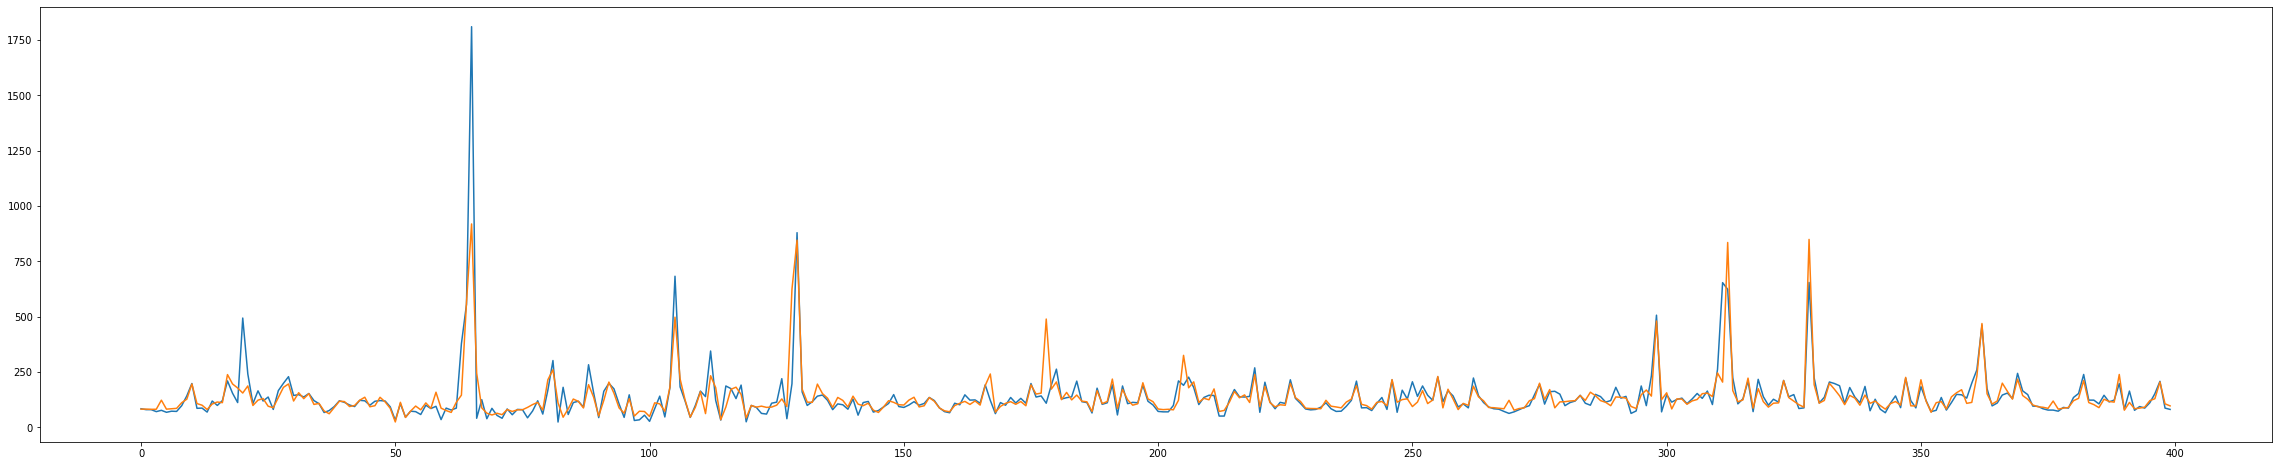

In [143]:
plt.figure(figsize=(40,8))
plt.plot(np.arange(y_test[10000:10400].shape[0]), y_test[10000:10400])
plt.plot(np.arange(y_test[10000:10400].shape[0]), y_pred[10000:10400])

In [49]:
#export model
model.save_weights('./checkpoint/traveltime_model.cpkt')

### Prediction and tolerence Intervals : 

In [71]:
epsilon = error

In [57]:
import scipy
import random

In [3]:
model.load_weights('./checkpoint/Many_to_one.cpkt');

NameError: name 'model' is not defined

In [30]:
y_pred = model.predict(test_data)

In [31]:
epsilon = (y_test - y_pred)

In [32]:
epsilon = epsilon.reshape(-1)
epsilon.shape

(717310,)

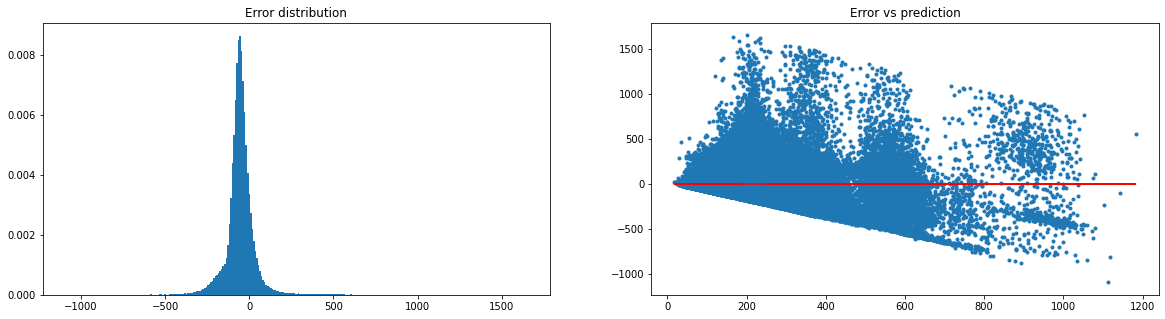

In [72]:
fig, axs = plt.subplots(1, 2, figsize = (20,5) )
axs[0].set_title('Error distribution')
_, bins, _ = axs[0].hist(epsilon, bins=300, density = True)
axs[1].set_title('Error vs prediction')
axs[1].plot(y_pred, epsilon, '.')
axs[1].plot(y_pred, np.zeros(y_pred.shape[0]), 'r-')

plt.show()

In [73]:
sample = random.sample(epsilon.reshape(-1,).tolist(), 4000)

In [74]:
scipy.stats.shapiro(sample)

ShapiroResult(statistic=0.7577173113822937, pvalue=0.0)

showing the histogram, we can intuitively make the hypothesis that the error distribution follows a normal distribtion <br>
If this hypothesis is correct, we can easily extract a prediction interval using the gaussian statistics table. <br>
Unfortenuatly, the shapiro test reject the null hypothesis. thus, we need first to estimate a kernel density for the error distribution, then we use the 5th and 95th kernel density percentiles to extract the prediction intervals. <br>
we can also use a straitforward emperical approach by extracting the 5th and 95th percentiles emperically from the error distrivution since we are in possession of a huge amount of data. or we can apply the bootstraping prediction interval approach using montecarlo simulation.

#### Emperical prediction intervals : 

In [75]:
lower = np.percentile(epsilon, 5)
upper = np.percentile(epsilon, 95)

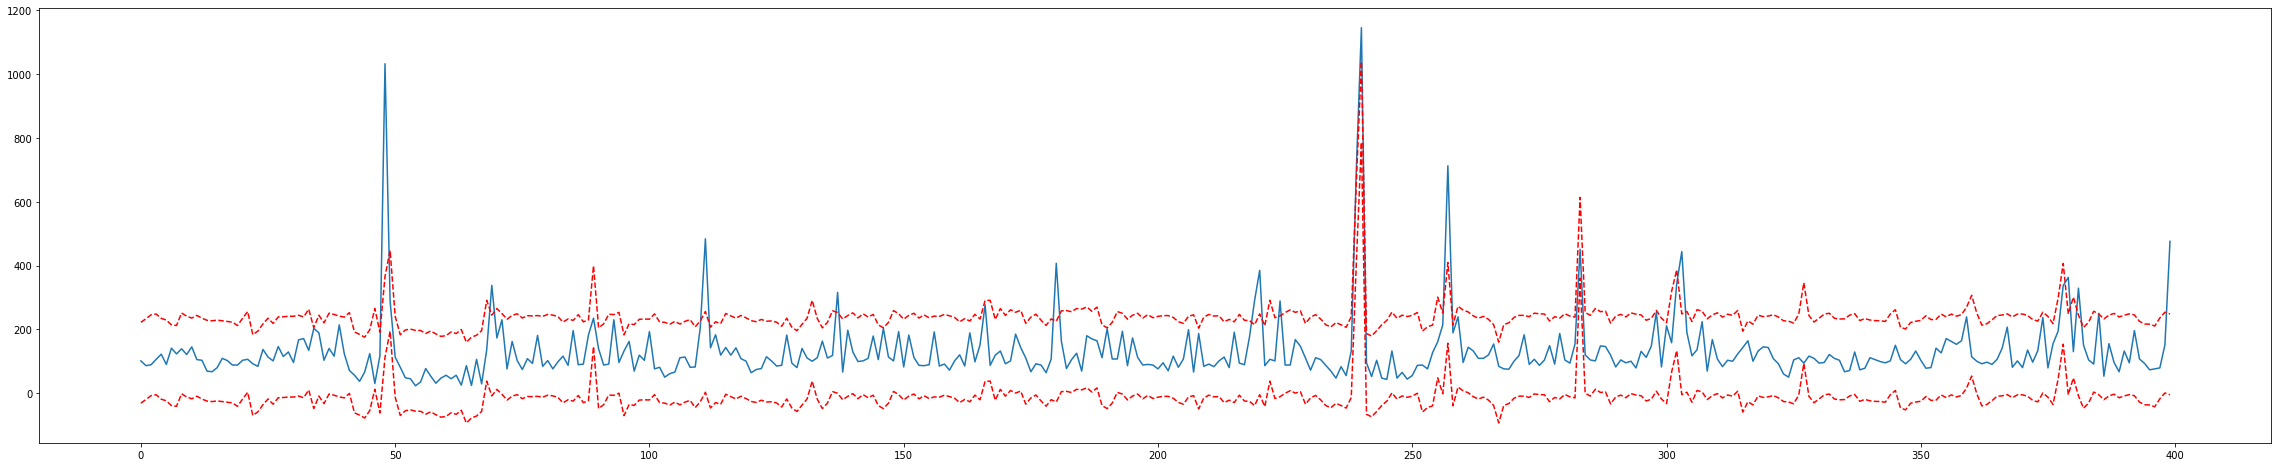

In [96]:
plt.figure(figsize=(40,8))
plt.plot(np.arange(y_test[10000:10400].shape[0]), y_test[10000:10400])
plt.plot(np.arange(y_test[10000:10400].shape[0]), y_pred[10000:10400] + lower, 'r--')
plt.plot(np.arange(y_test[10000:10400].shape[0]), y_pred[10000:10400] + upper, 'r--')

#plt.plot(np.arange(y_test[10000:10400].shape[0]), y_pred[10000:10400])

In [79]:
y_pred = y_pred.reshape(-1,)

In [80]:
in_boundries = y_pred[((y_pred + lower) < y_test) & ((y_pred + upper) > y_test)].shape[0]

In [81]:
all_inputs = y_pred.shape[0]

In [94]:
in_boundries*100 / all_inputs

89.99995926663652

In [93]:
lower_boundries = y_pred[(y_pred + lower) < y_test].shape[0]
lower_boundries*100 / all_inputs

94.99997963331826

In [91]:
upper_boundries = y_pred[(y_pred + upper) > y_test].shape[0]
upper_boundries*100 / all_inputs

94.99997963331826

<AxesSubplot:>

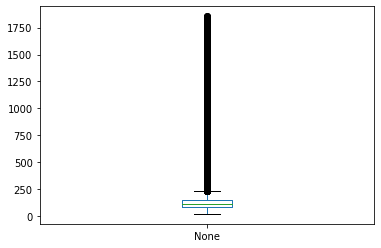

In [95]:

pd.Series(y_test).plot(kind='box')

#### Bootstraping prediction interval method : (Monte carlo simulation) 

In [ ]:
#link
#https://towardsdatascience.com/stock-price-prediction-intervals-using-monte-carlo-simulation-6b52b8ac9c27
#https://gist.github.com/jkclem/b16f9d8cd0a9e817fd3baa3ce3cd0194

In [98]:
# produces a summary of the residuals
pd.Series(epsilon).describe()

count    490998.000000
mean        -51.968114
std         100.245164
min       -1091.816895
25%         -87.772697
50%         -55.098366
75%         -20.420879
max        1649.457367
dtype: float64

In [ ]:
# imports the fitter function and produces estimated fits for our residuals
from fitter import Fitter
warnings.filterwarnings('ignore')

f = Fitter(epsilon[:10000])
f.fit()
f.summary

#### Prediction interval methods Evaluation : 

#### Tolerence interval : 90%